In [41]:
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import csv
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib.colors as mcolors
import datetime as dt

## Wind Only LCOE

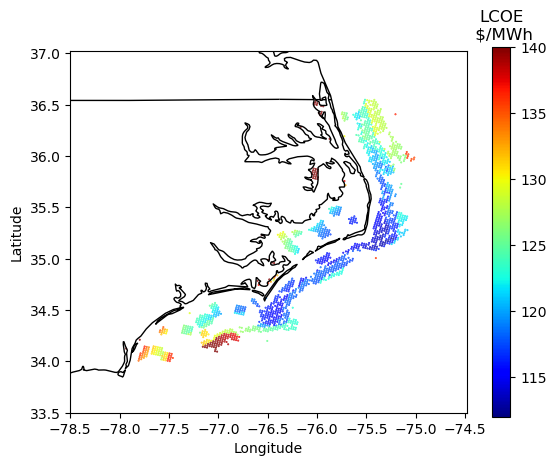

In [42]:
ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"

HourlyData=np.load('WindEnergyNREL_100m_Haliade150_6MW.npz', allow_pickle=True)

#Indexes from 2009-2013
FromDate=dt.datetime(2007,1,1,0)
FirstIDX=(dt.datetime(2009,1,1,0)-FromDate).days*24
LastIDX=(dt.datetime(2014,1,1,0)-FromDate).days*24

HourlyCurrentEnergy=HourlyData["WindEnergy"][:,FirstIDX: LastIDX]
AvgCurrentEnergy=np.average(HourlyCurrentEnergy,axis=1)
WindCF=AvgCurrentEnergy
LatLong=HourlyData["LatLong"]
X_LAT_Wind=LatLong[:,1]
Y_LONG_Wind=LatLong[:,0]




DepthSites=HourlyData["Depth"]
ShoreDistance=HourlyData["DistanceToShore"]

AnnualizedCostWind=HourlyData["AnnualizedCostWind"]
RatedPower=HourlyData["RatedPower"]/10**6

LCOE=[]
for i in range(len(AvgCurrentEnergy)):
    LCOE_i=AnnualizedCostWind[i]/(AvgCurrentEnergy[i]*RatedPower*8766)*10**6
    LCOE.append(LCOE_i)

LCOE=np.array(LCOE)
LCOE_Wind=LCOE

min_longitude=-78.5
max_longitude=-74.5+1/50

min_latitude=33.5 
max_latitude=37+1/50

xlim =[min_longitude,max_longitude]
ylim=[min_latitude, max_latitude]

df = gpd.read_file(ShapeFileCoast)
df1 = gpd.read_file(ShapeFileStates)

fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)


plt.scatter(LatLong[:,1],LatLong[:,0], c=LCOE, s=0.2, cmap='jet')
plt.clim(np.floor(min(LCOE)),140)

clb = plt.colorbar()
clb.ax.set_title('LCOE\n $/MWh')


ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#plt.title("Wind Energy LCOE")

plt.savefig('Figures/LCOE_WindNC_2009_2013.png',bbox_inches='tight',dpi=700)


##  Wind

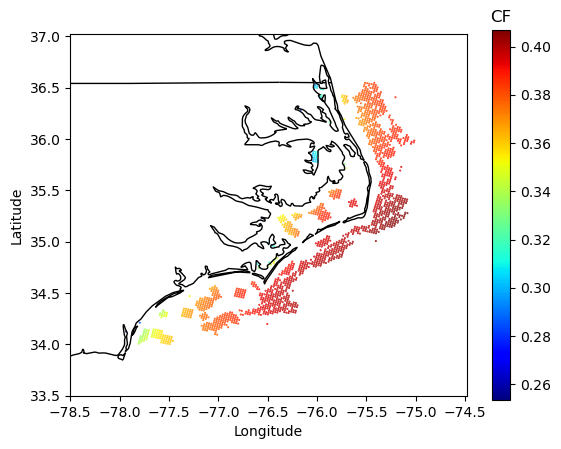

In [43]:

min_longitude=-78.5
max_longitude=-74.5+1/50

min_latitude=33.5 
max_latitude=37+1/50

xlim =[min_longitude,max_longitude]
ylim=[min_latitude, max_latitude]

df = gpd.read_file(ShapeFileCoast)
df1 = gpd.read_file(ShapeFileStates)

fig, ax = plt.subplots(figsize  = None)

df.plot(color='black',linewidth=1,ax=ax)
df1.plot(color='black',linewidth=1,ax=ax)


plt.scatter(LatLong[:,1],LatLong[:,0], c=AvgCurrentEnergy, s=0.2, cmap='jet')
#plt.clim(np.floor(min(LCOE)),140)

clb = plt.colorbar()
clb.ax.set_title('CF')


ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#plt.title("Wind Energy LCOE")

plt.savefig('Figures/CF_WindNC_2009_2013.png',bbox_inches='tight',dpi=700)


## Combine Kite+Wind

In [44]:
#Data=np.load("SaveSeabed.npz",allow_pickle=True)
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"][0]
long=Data["long"][0]

LCOE_Kite=np.ones((50,50))*-1
kW_Kite=np.ones((50,50))*-1
Variable2=np.ones((50,50))*-1

X_LAT=np.zeros((int(len(lat)*len(long))),dtype=float)
Y_LONG=np.zeros((int(len(lat)*len(long))),dtype=float)

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    LCOE_Kite[a,b]=Results[i]["LCOEBest"]*1000
    kW_Kite[a,b]=Results[i]["Power"]
    
    Variable2[a,b]=Results[i]["LCOEBest"]*1000
    
count=0   
for I_lat in range(len(lat)):
    for I_long in range(len(long)):

      Y_LONG[count]=lat[I_lat]
      X_LAT[count]=long[I_long]
      count=count+1
    
    
LCOE_Kite=np.reshape(LCOE_Kite,(-1))
kW_Kite=np.reshape(kW_Kite,(-1))


X_LAT_Kite=X_LAT[LCOE_Kite<300]
Y_LONG_Kite=Y_LONG[LCOE_Kite<300]
kW_Kite=kW_Kite[LCOE_Kite<300]
LCOE_Kite=LCOE_Kite[LCOE_Kite<300]

In [64]:
idxKite=[]
for i in range(len(X_LAT_Wind)):
    
    Distance=((X_LAT_Wind[i]-X_LAT_Kite)**2 + (Y_LONG_Wind[i]-Y_LONG_Kite)**2)**(1/2)
    #any kite close enough? 
    if np.sum(Distance<0.06)!=0:
        idxKite.append(np.argmin(Distance))
    
    else:
        idxKite.append(-1)

idxKite=np.array(idxKite)

In [74]:
LatCombined=X_LAT_Wind[idxKite!=-1]
LongCombined=Y_LONG_Wind[idxKite!=-1]

LCOECombined=(LCOE_Wind[idxKite!=-1]*WindCF[idxKite!=-1]*6*8760 +\
              LCOE_Kite[idxKite[idxKite!=-1]]*kW_Kite[idxKite[idxKite!=-1]]/1000*8760)/(WindCF[idxKite!=-1]*6*8760+kW_Kite[idxKite[idxKite!=-1]]/1000*8760)

PD_LCOECombined=(LCOE_Wind[idxKite!=-1]-LCOECombined)/LCOE_Wind[idxKite!=-1]*100
              

In [90]:
def plotWK(X_LAT,Y_LONG,Var):
    
#     min_longitude=-78.5
#     max_longitude=-74.5+1/50

#     min_latitude=33.5 
#     max_latitude=37+1/50

    min_longitude=-76
    max_longitude=-74.5+1/50

    min_latitude=35
    max_latitude=35.5
    
    xlim =[min_longitude,max_longitude]
    ylim=[min_latitude, max_latitude]
    
    ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
    ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
    df = gpd.read_file(ShapeFileCoast)
    df1 = gpd.read_file(ShapeFileStates)

    fig, ax = plt.subplots(figsize  = None)

    df.plot(color='black',linewidth=1,ax=ax)
    df1.plot(color='black',linewidth=1,ax=ax)


    #plt.scatter(X_LAT,Y_LONG, c=-Var, s=0.2, cmap='jet')
    plt.scatter(X_LAT,Y_LONG, c=-Var, s=2, cmap='jet')
    #plt.clim(np.floor(min(LCOE)),140)

    clb = plt.colorbar()
    clb.ax.set_title('% Increase in \n LCOE')


    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    #plt.title("Wind Energy LCOE")

    plt.savefig('Figures/LCOE_WindKite.png',bbox_inches='tight',dpi=700)

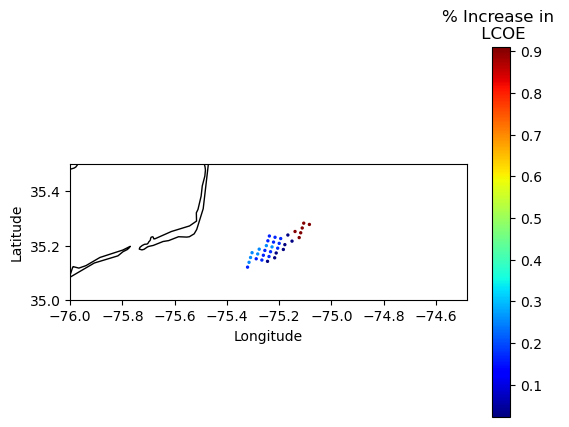

In [91]:
plotWK(LatCombined,LongCombined,PD_LCOECombined)